In [31]:
%store -r

In [ ]:
# read the polaris data for Boulder Couunty area slicing out parts of 1 degree segments
# Applicable components from http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/Readme for
# Blue Spruce (Picea pungens) 
# Native Range latitude 33° 50' to 48° 54' N. and from longitude 104° 45' to 114° 00' W.
# Soil pH is 6.8 to 7.2, neutral to slightly alkaline
# Preference for Mollisols - soils that have a dark colored surface horizon relatively high in content of organic matter. 
# The soils are base rich throughout and therefore quite fertile. 
# Reference https://www.nrcs.usda.gov/conservation-basics/natural-resource-concerns/soils/mollisols
# also to a lesser extent, in the orders Histosols not in Colorado as per https://www.nrcs.usda.gov/conservation-basics/natural-resource-concerns/soils/histosols 
# and Inceptisols (page not working at https://www.nrcs.usda.gov/conservation-basics/natural-resource-concerns/soils/inceptisols)
# alternative https://en.wikipedia.org/wiki/Inceptisol
#
# for Mollisoils
# given the GGPT prompt described at https://docs.google.com/document/d/14sLLOeQOxcq4QF18y1n87_whPe-L5IbbmUMCpcOiXJ0/edit?usp=sharing
# silt	%	Generally high, around 30-50%, with a gradual decrease with depth.
# sand	%	Moderately low, around 20-40%, increasing with depth.
# clay	%	Moderate, around 20-40%, increasing with depth due to leaching and accumulation.
# bd (bulk density)	g/cm³	Low in surface layers due to organic matter, around 1.1-1.3 g/cm³, increasing to 1.4-1.6 g/cm³ in deeper layers.
# theta_s	m³/m³	High in organic-rich topsoil, around 0.40-0.50, decreasing slightly with depth.
# theta_r	m³/m³	Low, around 0.05-0.10 for most depths.
# ksat	log10(cm/hr)	Moderately high in surface layers due to organic matter, around 1.0-2.0 log10(cm/hr), decreasing in lower layers to 0.0-1.0 log10(cm/hr).
# ph	N/A	Neutral to slightly basic, around 6.5-7.5 in surface layers, may vary slightly with depth but generally remains neutral.
# om (organic matter)	log10(%)	High in surface layers, around 1.0-2.0 log10(%), sharply decreasing with depth to <0.5 log10(%) beyond 30 cm.
# lambda	N/A	Moderately high in surface layers, around 0.3-0.6, indicative of good water retention properties, decreasing with depth.
# hb	log10(kPa)	Low in surface layers, around 1.0-1.5 log10(kPa), increasing with depth due to soil compaction and smaller pore spaces.
# n (pore size distribution, van Genuchten)	N/A	Around 1.2-1.5, indicating moderate pore size uniformity in the surface layers, may increase slightly with depth.
# alpha	log10(kPa⁻¹)	Around -2.0 to -2.5 log10(kPa⁻¹), reflecting the moderately high pore sizes in surface layers, decreasing slightly with depth.


# root depth
# Even in mature trees, the root system of blue spruce is relatively shallow, compared to that of Douglas-fir and ponderosa pine, adapting it to the moist site on which it usually grows. 
# In spite of the shallow root system, blue spruce is decidedly windfirm.
# now ref https://plants.usda.gov/plant-profile/PIPU
# Root Depth Characteristics
# Shallow to Moderate Depth: 
# Blue spruce typically has a shallow to moderate root system, 
# with most of the roots found within the top 18 to 24 inches (45 to 60 cm) of soil.
# Lateral Spread: While the roots are not deeply penetrating, they spread widely, 
# often extending well beyond the canopy drip line, particularly in mature trees.
# Factors Influencing Root Depth
# Soil Type:
# In sandy or well-drained soils, roots may penetrate deeper, up to 2-3 feet (60-90 cm).
# In clayey or compacted soils, roots remain closer to the surface due to poor aeration and waterlogging.
# Water Availability:
# In areas with consistent rainfall or irrigation, root systems remain relatively shallow.  *** BUFFER hydro
# In drier environments, roots may grow slightly deeper in search of water.

# For Picea pungens (blue spruce), when considering Mollisols or any soil type, 
# the most important factor apart from pH is likely drainage and moisture retention, 
# which is closely linked to soil texture and bulk density

In [49]:
import rioxarray as rxr
import pathlib
import os
from math import floor, ceil

import geopandas as gpd

In [40]:
# sample link ph for 30 to 60 cm depth Picea pungens prefers 45-60 
# http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4041_lon-106-105.tif
# 

soil_url_scan = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
            "ph/mean/30_60/"
            "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")

soil_url = soil_url_scan.format(min_lat=39, max_lat=40, min_lon=-106, max_lon=-105)


In [57]:
bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (boulder_gdf.total_bounds)

soi_url_list = []
for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
    for min_lat in range (floor(bounds_min_lat), ceil(bounds_max_lat)):
        # print(min_lon, min_lat)
        soil_url = soil_url_scan.format(
            min_lat=min_lat, max_lat=min_lat+1,
            min_lon=min_lon, max_lon=min_lon+1)
        soi_url_list.append(soil_url)

soi_url_list

['http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat3940_lon-106-105.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4041_lon-106-105.tif']

In [41]:
#soil_da = rxr.open_rasterio(soil_url, mask_and_scale=True).squeeze # causes a problem  aha forgot the ()
soil_da = rxr.open_rasterio(soil_url, mask_and_scale=True).squeeze()

soil_da

<xarray.DataArray (y: 3600, x: 3600)> Size: 52MB
[12960000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB -106.0 -106.0 -106.0 ... -105.0 -105.0 -105.0
  * y            (y) float64 29kB 40.0 40.0 40.0 40.0 ... 39.0 39.0 39.0 39.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area

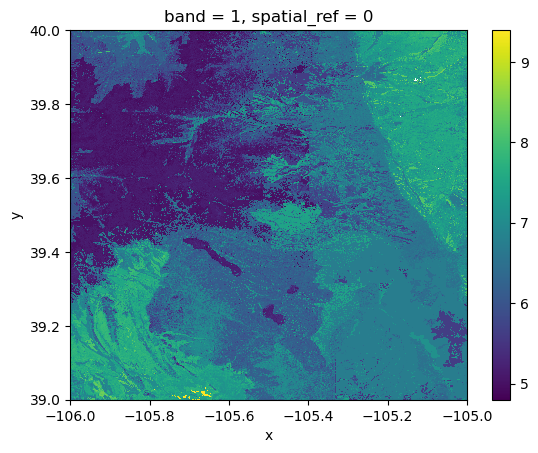

In [42]:
soil_da.plot()

<Axes: >

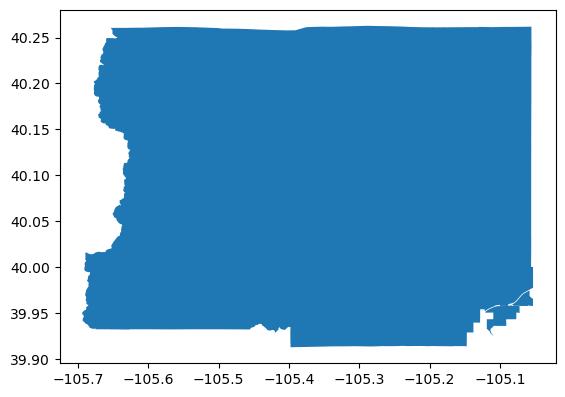

In [34]:
boulder_gdf.plot()